# Baselines

### Preamble

In [3]:
SYS_PATH = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
SAVE_PATH = r"C:/Users/mark/Documents/GitHub/honours/submissions/thesis-original"
LOAD_PATH = r"C:/Users/mark/Documents/GitHub/honours/dev/package/analysis/output/temp/output.db"

In [4]:
#standard imports
import sys
import numpy as np
import scipy.stats as stats
import pandas as pd
from datetime import date, timedelta
import math
from itertools import chain
import pickle

#third party imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as tkr
import seaborn as sns
from sklearn import metrics

In [5]:
import importlib
import sys; sys.path.append(SYS_PATH)
import analysis.autoVC2 as vc
import analysis.helper as helper
importlib.reload(vc)
importlib.reload(helper)
%matplotlib inline

In [6]:
%matplotlib inline

TINY_SIZE, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE  = 12, 16, 20, 30
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_palette("colorblind")
rcParams['font.family'] = 'serif' 
rcParams['font.serif'] = 'CMU Serif' 
rcParams['font.weight'] = 'bold'
rcParams['font.size'] = SMALL_SIZE #default font size
rcParams['axes.titlesize'] =SMALL_SIZE   # fontsize of the axes title
rcParams['axes.labelsize'] =MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] =SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] =SMALL_SIZE   # fontsize of the tick labels
rcParams['legend.fontsize'] =SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] =BIGGER_SIZE  # fontsize of the figure title
rcParams['figure.figsize'] = (8,3)
pd.set_option('precision',3)
outline_bars = dict(linewidth = 1.25, edgecolor = '.15')

### Investment success by forecast window

In [109]:
reload = True

In [110]:
chart_id = "figures/evaluation/outcomes_window"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [111]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = pd.read_pickle(SYS_PATH+"analysis/output/autoVC/17/merge_output.pkl")
    data["forecast_window"] = data["label_date"] - data["feature_date"]
    data["forecast_window_years"] = data["forecast_window"].apply(lambda x: x.days // 30) / 12
    data = data.loc[data["forecast_window_years"] > 0]
    data["outcome_extra_stage_number"] = data["outcome_stage_number"] - data["keys_company_stage_number"]
    data["outcome_extra_stage_bool"] = np.where(data["outcome_extra_stage_number"] > 0, 1, 0)
    data["Outcome"] = "No Change"
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_closed_bool"] >= 1), "Closed", data["Outcome"])
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_ipo_bool"] >= 1), "IPO", data["Outcome"])
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_acquired_bool"] >= 1), "Acquired", data["Outcome"])
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_extra_stage_bool"] >= 1), "Raised", data["Outcome"])
    data["Outcome"].value_counts()
    data = data[["Outcome", "keys_company_stage","forecast_window_years"]]
    data.to_pickle(pickle_path)

In [112]:
x = "forecast_window_years"
y = "Count"
hue = "Outcome"
hue_order = ["Raised", "Acquired", "IPO", "Closed"]

In [113]:
x_label = "Forecast Window (Years)"
y_label = "Companies (%)"
leg_title = "Outcome"

In [114]:
data["forecast_window_years"] = data["forecast_window_years"].astype(int)
results = data.groupby(x)[hue].value_counts(normalize=True).to_frame()
results = results.rename(index=str, columns={hue:"Count"})
results["Count"] = results["Count"] * 100
results = results.reset_index(drop=False)
results["Count"] = np.where(results["Outcome"] == "Closed", results["Count"] * -1, results["Count"])

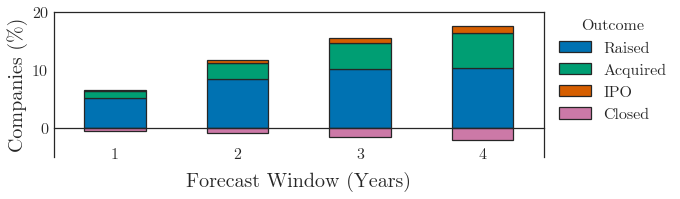

In [115]:
yo = results.groupby([x,hue])[y].sum()
ax = yo.unstack()[hue_order].plot(kind="bar",stacked=True, **outline_bars,zorder=-10)
f = plt.gcf()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.spines['bottom'].set_position('zero')
ax.xaxis.labelpad = 10
ax.xaxis.set_tick_params(pad=20)
ax.set_ylim(ymin=-5, ymax=20)
plt.legend(bbox_to_anchor=(1,1.05), title=leg_title)
plt.tight_layout()

In [116]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Investment success by developmental stage

In [118]:
reload = True

In [119]:
chart_id = "figures/evaluation/outcomes_stage"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [120]:
def get_data():
    data = pd.read_pickle(SYS_PATH+"analysis/output/autoVC/17/merge_output.pkl")
    data["forecast_window"] = data["label_date"] - data["feature_date"]
    data["forecast_window_years"] = data["forecast_window"].apply(lambda x: x.days // 30) / 12
    data = data.loc[data["forecast_window_years"] > 0]
    data["outcome_extra_stage_number"] = data["outcome_stage_number"] - data["keys_company_stage_number"]
    data["outcome_extra_stage_bool"] = np.where(data["outcome_extra_stage_number"] > 0, 1, 0)
    data["Outcome"] = "No Change"
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_closed_bool"] >= 1), "Closed", data["Outcome"])
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_ipo_bool"] >= 1), "IPO", data["Outcome"])
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_acquired_bool"] >= 1), "Acquired", data["Outcome"])
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_extra_stage_bool"] >= 1), "Raised", data["Outcome"])
    data["Outcome"].value_counts()
    data = data[["Outcome", "keys_company_stage","forecast_window_years"]]
    return data

In [121]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_data()
    data.to_pickle(pickle_path)

In [122]:
x = "keys_company_stage"
y = "Count"
hue = "Outcome"
hue_order = ["Raised", "Acquired", "IPO", "Closed"]
x_label = "Initial Developmental Stage"
y_label = "Companies (%)"
leg_title = "Outcome"

In [123]:
results = data.groupby(x)[hue].value_counts(normalize=True).to_frame()
results = results.rename(index=str, columns={hue:"Count"})
results["Count"] = results["Count"] * 100
results = results.reset_index(drop=False)
results["Count"] = np.where(results["Outcome"] == "Closed", results["Count"] * -1, results["Count"])
results = results.groupby([x,hue])[y].sum()
results = results.unstack()[hue_order]

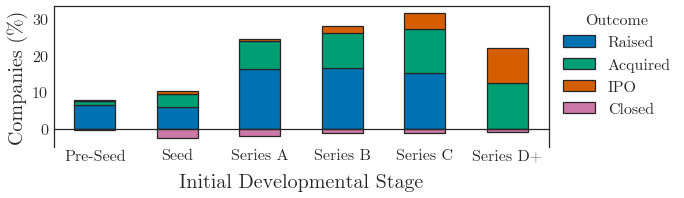

In [124]:
ax = results.plot(kind="bar",stacked=True, **outline_bars)
f = plt.gcf()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.spines['bottom'].set_position('zero')
ax.xaxis.labelpad = 10
ax.xaxis.set_tick_params(pad=20)
ax.set_ylim(ymin=-5)
plt.legend(bbox_to_anchor=(1,1.05), title=leg_title)
plt.tight_layout()

In [108]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Dataset counts over time

In [23]:
reload = False

In [24]:
chart_id = "figures/design/counts_stage_slice"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [25]:
def get_data():
    data = pd.read_pickle(SYS_PATH+"analysis/output/autoVC/17/output.pkl")
    data["Slice"] = data["date"].apply(lambda x: x.year)
    return data

In [26]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_data()
    data.to_pickle(pickle_path)

In [27]:
x = "Slice"
y = "Count"
hue = "stage"
hue_order = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+"]
x_label = "Slice Date"
y_label = "Companies"
leg_title = "Developmental Stage"

In [28]:
results = data.groupby(x)[hue].value_counts(normalize=False).to_frame()
results = results.rename(index=str, columns={hue:"Count"})
results["Count"] = results["Count"] / 1e3
results = results.reset_index(drop=False)
results = results.groupby([x,hue])[y].sum()
results = results.unstack()[hue_order]

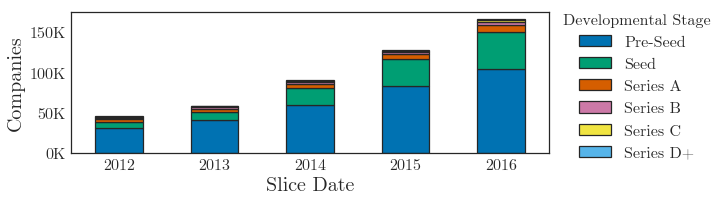

In [31]:
ax = results.plot(kind="bar",stacked=True, **outline_bars)
f = plt.gcf()
ax.set_yticklabels(["{:,.0f}K".format(ytick) for ytick in ax.get_yticks().tolist()])
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.spines['bottom'].set_position('zero')
plt.legend(bbox_to_anchor=(1,1.1), title=leg_title)
plt.tight_layout()

In [32]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Dataset slice compared to original database

In [7]:
chart_id = "figures/design/counts_slice_method"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [8]:
index=["People", "Companies", "Rounds", "Acquisitions", "IPOs"]

sliced = pd.DataFrame({"Counts":[216.146, 179.351,49.131,8.882,.790]}, index=index)
original = pd.DataFrame({"Counts": [226.709, 196.553,52.928,9.562,1.259]},index=index)

sliced["Method"] = "Slice"
original["Method"] = "Original"
counts = pd.concat([sliced, original], axis=0)

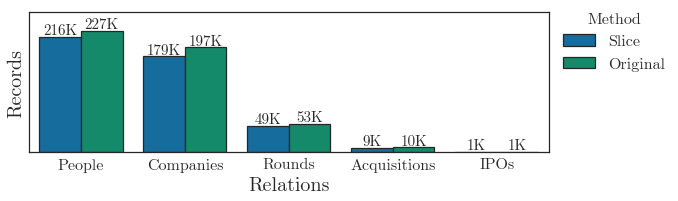

In [9]:
f = plt.figure()
ax = sns.barplot(x=counts.index, y=counts["Counts"], hue=counts["Method"], **outline_bars)
helper.auto_label(ax, fmt='{:,.0f}K', size=SMALL_SIZE-1)
ax.set_xlabel("Relations")
ax.set_ylabel("Records")
plt.legend(bbox_to_anchor=(1,1.1), title="Method", loc="upper left")
plt.tight_layout()

In [10]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")